## Trabajo Práctico Número 3  - Logos de Coca-Cola



#### Consiga:

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en la carpeta ./images a partir del template ./template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo template del item 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [1]:
#importar librerías
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from imutils.object_detection import non_max_suppression

### Para mayor legibilidad del ejercicio, se implementarán las funciones como clases. 
##### Clase ImageData: encargada de cargar la imagen en un objeto.
##### Clase TemplateMatcher: contendrá los métodos para realizar la detección del template en la imagen, tanto detección única como múltiples detecciones.


In [2]:
class ImageData:
    """Clase para manejar la carga y procesamiento de imágenes.
    Atributos:
        name (str): Nombre del archivo de imagen.
        img (numpy.ndarray): Imagen original en formato BGR.
        rgb (numpy.ndarray): Imagen convertida a formato RGB.
        gray (numpy.ndarray): Imagen convertida a escala de grises.
        canny (numpy.ndarray): Imagen procesada con el detector de bordes Canny.
    """
    def __init__(self, path):
        self.name = os.path.basename(path)
        self.img = cv.imread(path)
        if self.img is None:
            raise ValueError(f'No se pudo cargar: {self.name}')
        self.rgb = cv.cvtColor(self.img, cv.COLOR_BGR2RGB)
        self.gray = cv.cvtColor(self.img, cv.COLOR_BGR2GRAY)
        self.canny = cv.Canny(self.gray, 100, 180, L2gradient=True)

In [3]:
class TemplateMatcher:
    """Clase para realizar la detección de un template en una imagen.
    Atributos:
        template (numpy.ndarray): Imagen del template en escala de grises.
        template_canny (numpy.ndarray): Imagen del template procesada con el detector de bordes Canny.
        method (int): Método de coincidencia de plantillas de OpenCV.
        scales (list): Lista de escalas para redimensionar la imagen durante la detección.
    """
    def __init__(self, template_path, canny_thresholds=(100, 150), method=cv.TM_CCORR_NORMED, scales=None):
        self.template = cv.imread(template_path, 0)
        self.template_canny = cv.Canny(self.template, *canny_thresholds, L2gradient=True)
        self.template_inverted = cv.bitwise_not(self.template)
        self.template_inverted_equalized = cv.equalizeHist(self.template_inverted)
        self.method = method
        self.scales = scales if scales is not None else [0.3, 0.65, 0.7500000000000002, 1, 1.5, 1.75, 2, 2.5, 4, 4.5]
    
    def detect_single(self, image, manual_scale=False, scale_range=(0.5, 4.5), scale_step=0.25):
        """Detecta una sola coincidencia del template en la imagen, con el mayor score
        Args:
            image (ImageData): Image data object containing rgb, gray, canny, and name.
            threshold (float): Minimum match score threshold.
            manual_scale (bool): If True, use scale_range and scale_step; otherwise, use predefined scales.
            scale_range (tuple): Range of scales for resizing (start, end).
            scale_step (float): Step size for scale range.
        
        Returns:
            tuple: (rectangle, score, scale) where rectangle is (x1, y1, x2, y2) or None if no detection.
        """
        if not manual_scale:
            scales = self.scales
        else:
            scales = np.arange(scale_range[0], scale_range[1], scale_step)
        
        w, h = self.template.shape[::-1]
        best_score, best_scale, best_loc, best_image_canny = -10, 0, None, None
        r = 1.0

        for s in scales:
            image_resized = cv.resize(image.gray, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
            if image_resized.shape[0] > h and image_resized.shape[1] > w:
                image_canny = cv.Canny(image_resized, 100, 180, L2gradient=True)
                res = cv.matchTemplate(image_canny, self.template_canny, self.method)
                min_val, max_val, _, max_loc = cv.minMaxLoc(res)
                if max_val > best_score:
                    best_score = max_val
                    best_scale = s
                    r = image.gray.shape[1] / float(image_resized.shape[1])
                    best_loc = max_loc
                    best_image_canny = image_canny
        
        if best_loc is None:
            print(f"Imagen: {image.name}, No se detectó el template.")
            return None, best_score, best_scale
        
        top_left = (int(best_loc[0] * r), int(best_loc[1] * r))
        bottom_right = (int((best_loc[0] + w) * r), int((best_loc[1] + h) * r))
        rect = (top_left[0], top_left[1], bottom_right[0], bottom_right[1])

        return rect, best_score, best_scale, best_image_canny

    def detect_single_inverted(self, image, manual_scale=False, scale_range=(0.5, 4.5), scale_step=0.25):
        if not manual_scale:
            scales = self.scales
        else:
            scales = np.arange(scale_range[0], scale_range[1], scale_step)

        w, h = self.template.shape[::-1]
        best_score, best_scale, best_loc, best_resized = -10, 0, None, None
        r = 1.0

        for s in scales:
            image_resized = cv.resize(image.gray, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
            if image_resized.shape[0] > h and image_resized.shape[1] > w:
                image_inverted = cv.bitwise_not(image_resized)
                image_eq = cv.equalizeHist(image_inverted)

                res = cv.matchTemplate(image_eq, self.template_inverted_equalized, self.method)
                min_val, max_val, _, max_loc = cv.minMaxLoc(res)
                if max_val > best_score:
                    best_score = max_val
                    best_scale = s
                    r = image.gray.shape[1] / float(image_resized.shape[1])
                    best_loc = max_loc
                    best_resized = image_eq  # para visualizar correctamente luego

        if best_loc is None:
            print(f"Imagen: {image.name}, No se detectó el template (invertido + ecualizado).")
            return None, best_score, best_scale, None

        top_left = (int(best_loc[0] * r), int(best_loc[1] * r))
        bottom_right = (int((best_loc[0] + w) * r), int((best_loc[1] + h) * r))
        rect = (top_left[0], top_left[1], bottom_right[0], bottom_right[1])

        return rect, best_score, best_scale, best_resized

    def detect_multiple(self, image, threshold=0.140, manual_scale=False, scale_range=(0.5, 3.0), scale_step=0.1):
        """Método para detectar múltiples coincidencias del template en la imagen.
        Args:
            image (ImageData): Objeto de datos de imagen que contiene rgb, gray, canny, and name.
            threshold (float): Umbral mínimo de puntuación de coincidencia.
            manual_scale (bool): Si es True, usa scale_range y scale_step; de lo contrario, usa escalas predefinidas.
            scale_range (tuple): Rango de escalas para redimensionar (inicio, fin).
            scale_step (float): Tamaño del paso para el rango de escalas.
        Returns:
            tuple: (rects, scores, best_score, best_scale) donde rects es una lista de rectángulos (x1, y1, x2, y2),
                    scores es una lista de puntuaciones de coincidencia, best_score es la mejor puntuación
                    y best_scale es la escala utilizada para la mejor coincidencia.
        """

        if not manual_scale:
            scales = self.scales
        else:
            scales = np.arange(scale_range[0], scale_range[1], scale_step)

        w, h = self.template.shape[::-1]
        rects, scores, best_score, best_scale = [], [], -10, 0
        best_res, r = None, 1.0

        for s in self.scales:
            image_resized = cv.resize(image.gray, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
            if image_resized.shape[0] > h and image_resized.shape[1] > w:
                image_canny = cv.Canny(image_resized, 100, 180, L2gradient=True)
                res = cv.matchTemplate(image_canny, self.template_canny, self.method)
                min_val, max_val, _, _ = cv.minMaxLoc(res)
                if max_val > best_score:
                    best_scale = s
                    r = image.gray.shape[1] / float(image_resized.shape[1])
                    best_score = max_val
                    best_res = res
        
        if best_res is not None:
            loc = np.where(best_res >= threshold)
            for pt in zip(*loc[::-1]):
                rects.append((int(pt[0] * r), int(pt[1] * r), int((pt[0] + w) * r), int((pt[1] + h) * r)))
                scores.append(best_res[pt[1], pt[0]])
        
        rects = np.array(rects)
        if len(rects) > 0:
            rects = non_max_suppression(rects, probs=scores, overlapThresh=0.3)
        
        return rects, scores, best_score, best_scale
    

    def detect_multiple_inverted(self, image, threshold=0.14, manual_scale=False, scale_range=(0.5, 3.0), scale_step=0.1):
        if not manual_scale:
            scales = self.scales
        else:
            scales = np.arange(scale_range[0], scale_range[1], scale_step)

        w, h = self.template.shape[::-1]
        rects, scores, best_score, best_scale = [], [], -10, 0
        best_res, r = None, 1.0

        for s in scales:
            image_resized = cv.resize(image.gray, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
            if image_resized.shape[0] > h and image_resized.shape[1] > w:
                image_inverted = cv.bitwise_not(image_resized)
                res = cv.matchTemplate(image_inverted, self.template_inverted, self.method)
                min_val, max_val, _, _ = cv.minMaxLoc(res)
                if max_val > best_score:
                    best_score = max_val
                    best_scale = s
                    r = image.gray.shape[1] / float(image_resized.shape[1])
                    best_res = res

        if best_res is not None:
            loc = np.where(best_res >= threshold)
            for pt in zip(*loc[::-1]):
                rects.append((int(pt[0] * r), int(pt[1] * r), int((pt[0] + w) * r), int((pt[1] + h) * r)))
                scores.append(best_res[pt[1], pt[0]])

        rects = np.array(rects)
        if len(rects) > 0:
            rects = non_max_suppression(rects, probs=scores, overlapThresh=0.3)

        return rects, scores, best_score, best_scale


    def visualize_single(self, image, rect, best_score, best_scale, image_processed, template_view='canny'):
        """
        Visualiza la detección del template en una imagen.

        Args:
            image (ImageData): Objeto de datos de imagen.
            rect (tuple): Rectángulo detectado (x1, y1, x2, y2) o None si no se detectó.
            best_score (float): Mejor puntuación de coincidencia.
            best_scale (float): Escala utilizada para la mejor coincidencia.
            image_processed (numpy.ndarray): Imagen procesada (Canny o invertida).
            template_view (str): 'canny', 'inverted' o 'normal'
        """
        img_rgb_copy = image.rgb.copy()
        if rect is not None:
            cv.rectangle(img_rgb_copy, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 255), 3)

        # Elegimos qué template mostrar
        if template_view == 'inverted':
            template_to_show = self.template_inverted
            title_template = 'Template invertido'
        elif template_view == 'normal':
            template_to_show = self.template
            title_template = 'Template original'
        else:
            template_to_show = self.template_canny
            title_template = 'Template con bordes de Canny'

        print(f"Imagen: {image.name}")
        print(f"Máximo: {np.round(best_score, 3)}")
        print(f"Nivel de Confianza:  {np.round(1 - best_score, 3)}")
        print(f"Escala: {best_scale}")

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(template_to_show, cmap='gray')
        plt.title(title_template)

        plt.subplot(1, 3, 2)
        plt.imshow(image_processed if image_processed is not None else image.canny, cmap='gray')
        plt.title('Imagen procesada')

        plt.subplot(1, 3, 3)
        plt.imshow(img_rgb_copy)
        plt.title(f"Nivel de confianza: {np.round(1 - best_score, 3)}")

        plt.savefig(f"output/ej1_{image.name}", dpi=300, bbox_inches='tight')
        plt.show()



    def visualize_multiple(self, image, rects, best_score, best_scale, template_view='canny'):
        """
        Visualiza múltiples detecciones en la imagen.

        Args:
            image (ImageData): Objeto de datos de imagen.
            rects (list): Lista de rectángulos detectados (x1, y1, x2, y2).
            best_score (float): Mejor puntuación de coincidencia.
            best_scale (float): Escala utilizada para la mejor coincidencia.
            template_view (str): 'canny', 'inverted' o 'normal'
        """
        img_rgb_copy = image.rgb.copy()
        for (x1, y1, x2, y2) in rects:
            cv.rectangle(img_rgb_copy, (x1, y1), (x2, y2), (0, 255, 255), 3)

        # Seleccionar qué template mostrar
        if template_view == 'inverted':
            template_to_show = self.template_inverted
            title_template = 'Template invertido'
        elif template_view == 'normal':
            template_to_show = self.template
            title_template = 'Template original'
        else:
            template_to_show = self.template_canny
            title_template = 'Template con bordes de Canny'

        # Mostrar imagen + template
        plt.figure(figsize=(8, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb_copy)
        plt.title(f"Detecciones: {len(rects)}, Escala: {best_scale}, Score: {np.round(best_score, 3)}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(template_to_show, cmap='gray')
        plt.title(title_template)
        plt.axis('off')

        plt.savefig(f"output/ej2_{image.name}", dpi=300, bbox_inches='tight')
        plt.show()

### Resolución de los puntos del Trabajo Práctico:

In [4]:
# Cargar imágenes desde el directorio './images'
image_dir = './images'
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]
images = [ImageData(os.path.join(image_dir, f)) for f in image_files]


In [5]:
# Inicializar el matcher con el template
# Cargamos el template desde './template/pattern.png'
template_matcher = TemplateMatcher('./template/pattern.png')

### Ejercicio 1: Ejecutar el método *detect_single* para encontrar la máxima coincidencia entre el template y la imagen, luego visualizarla con *visualize_single*

Imagen: COCA-COLA-LOGO.jpg
Máximo: 0.147
Nivel de Confianza:  0.853
Escala: 0.3


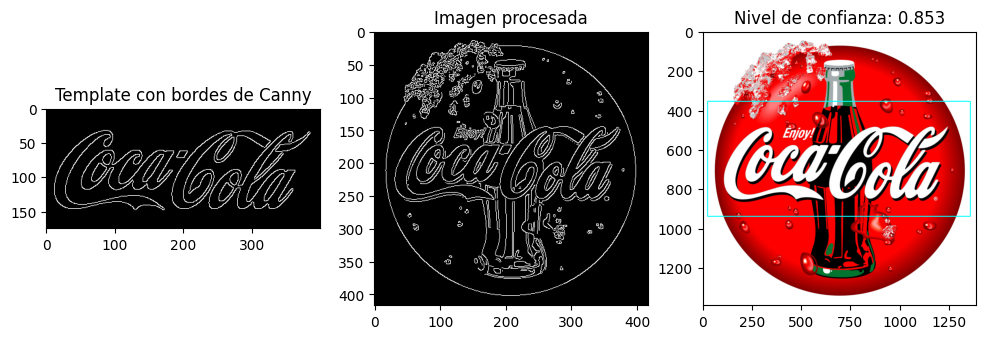

Imagen: coca_logo_1.png
Máximo: 0.181
Nivel de Confianza:  0.819
Escala: 2.5


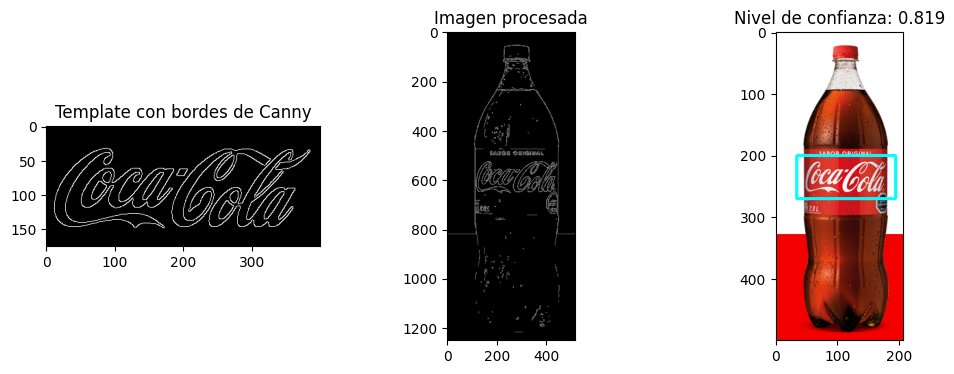

Imagen: coca_logo_2.png
Máximo: 0.136
Nivel de Confianza:  0.864
Escala: 1.75


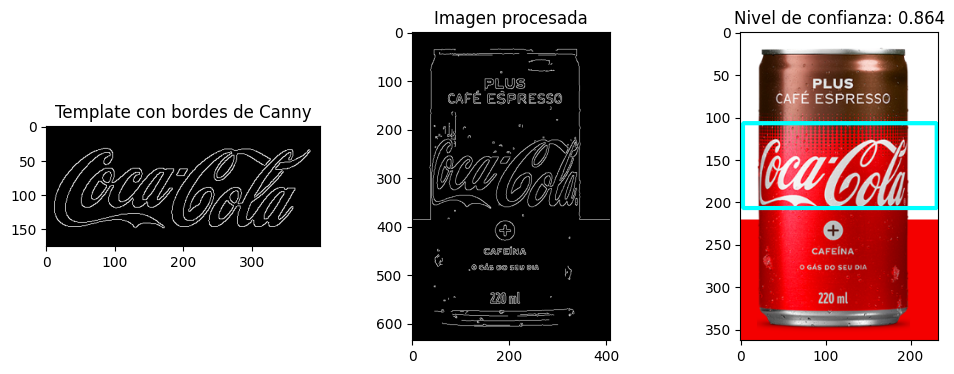

Imagen: coca_multi.png
Máximo: 0.181
Nivel de Confianza:  0.819
Escala: 4


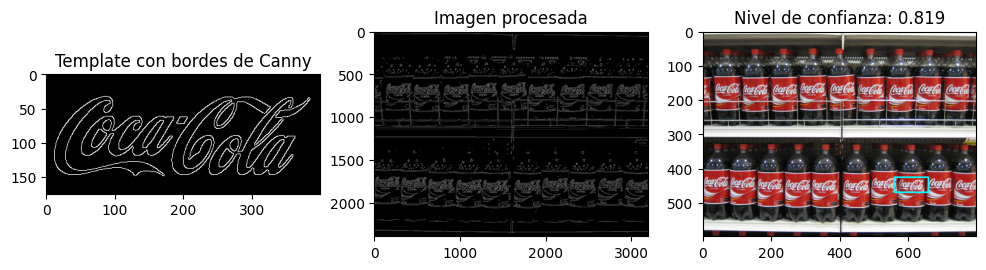

Imagen: coca_retro_1.png
Máximo: 0.181
Nivel de Confianza:  0.819
Escala: 0.7500000000000002


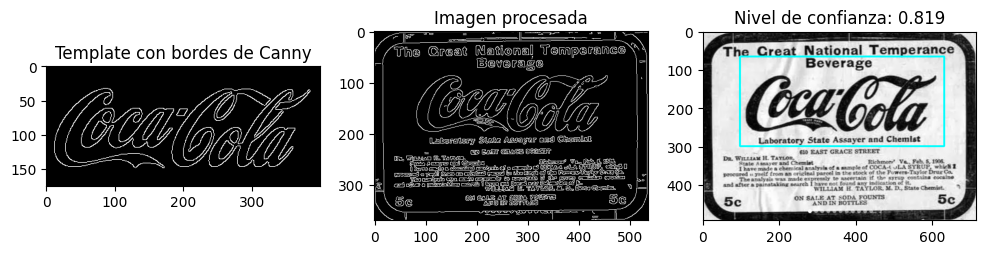

Imagen: coca_retro_2.png
Máximo: 0.224
Nivel de Confianza:  0.776
Escala: 2.5


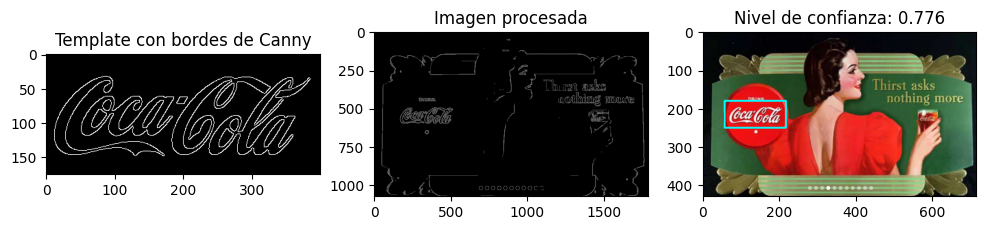

Imagen: logo_1.png
Máximo: 0.143
Nivel de Confianza:  0.857
Escala: 1.5


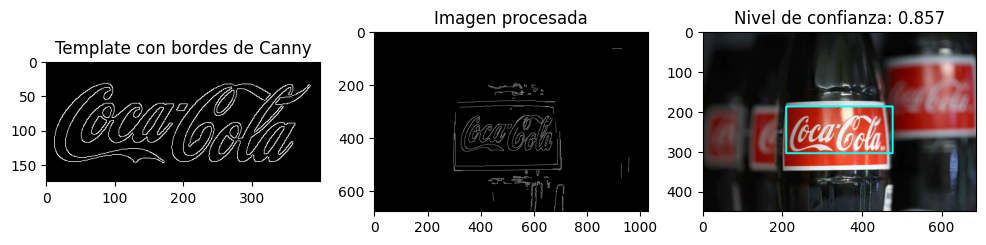

In [6]:
# Bucle para procesar cada imagen detectando el template
for image in images:
    rect, best_score, best_scale, image_canny = template_matcher.detect_single(image)
    template_matcher.visualize_single(image, rect, best_score, best_scale, image_canny)


Mediante el empleo de Canny para extracción de bordes y tanto en el template como en las imágenes, se observa una correcta detección del template en todas las imágenes.
El haber incluido la opción de un rango dinámico de escalamiento de imágenes permitió acotar el rango de escala a emplear y así reducir la ejecución en este dataset, pero ser lo suficientemente genérico en caso de incorporar nuevas imágenes.

Se realizaron pruebas escalando el template pero los resultados no fueron satisfactorios en las detecciones, en particular al comparar con la implementación que escala a la imagen. 



#### Comparación de métodos: Canny vs Inversión de colores

**Introducción**

En esta sección se comparan dos enfoques distintos para la detección de un logotipo utilizando *template matching*:

- **Método 1: Canny**  
  Se utiliza el detector de bordes de Canny para procesar tanto el template como la imagen objetivo. Este enfoque es robusto a variaciones de color, pero puede verse afectado por el ruido o detalles finos.

- **Método 2: Inversión de colores + Ecualización de histograma**  
  En este caso, se invierten los colores de la imagen y del template (negro sobre blanco → blanco sobre negro) y se aplica ecualización de histograma. Este método es útil cuando el contraste original entre fondo y letras es bajo o está invertido respecto al template original.

A continuación, se muestra el procesamiento y visualización de ambos métodos sobre cada imagen del conjunto.


=== Procesando imagen: COCA-COLA-LOGO.jpg ===
[Canny] Score: 0.147, Escala: 0.3
Imagen: COCA-COLA-LOGO.jpg
Máximo: 0.147
Nivel de Confianza:  0.853
Escala: 0.3


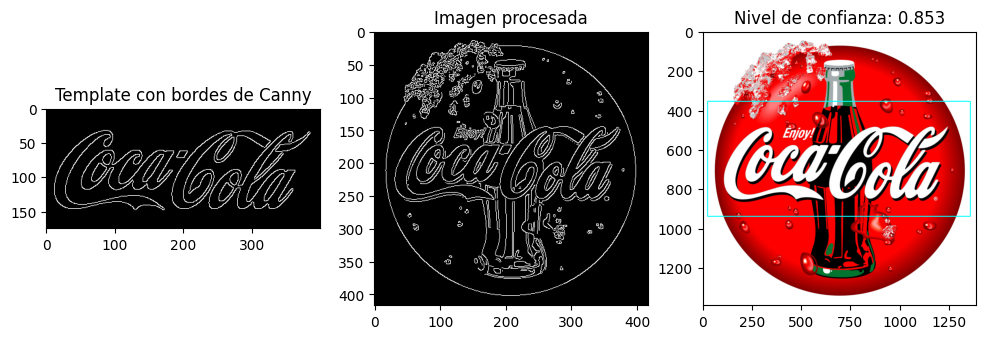

[Inversión] Score: 0.731, Escala: 4.5
Imagen: COCA-COLA-LOGO.jpg
Máximo: 0.731
Nivel de Confianza:  0.269
Escala: 4.5


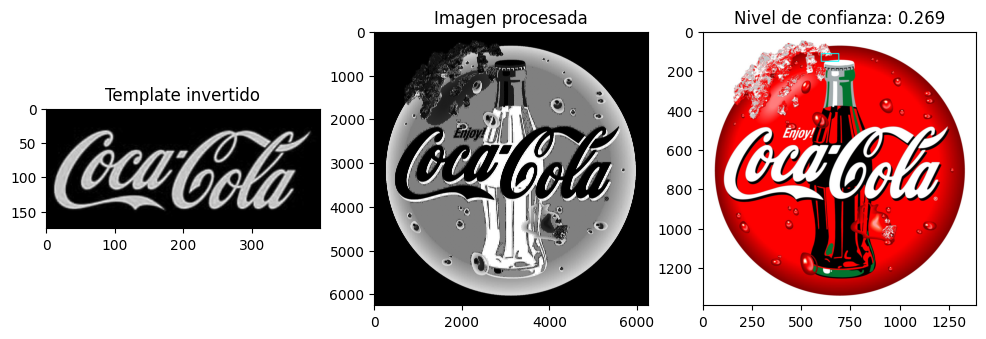


=== Procesando imagen: coca_logo_1.png ===
[Canny] Score: 0.181, Escala: 2.5
Imagen: coca_logo_1.png
Máximo: 0.181
Nivel de Confianza:  0.819
Escala: 2.5


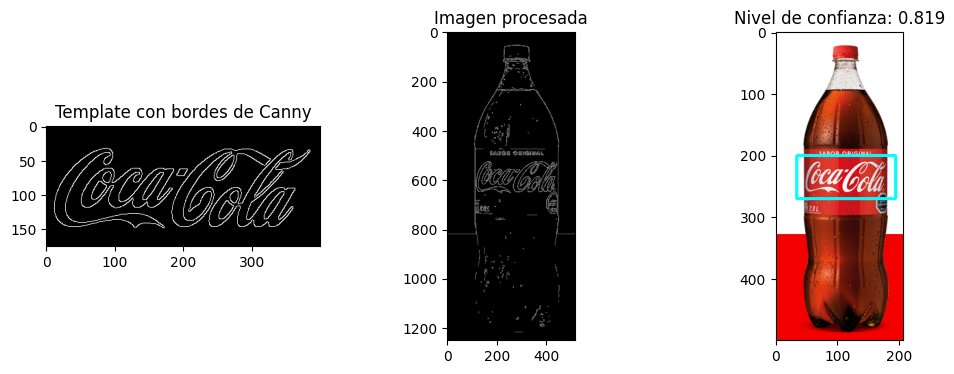

[Inversión] Score: 0.728, Escala: 4.5
Imagen: coca_logo_1.png
Máximo: 0.728
Nivel de Confianza:  0.272
Escala: 4.5


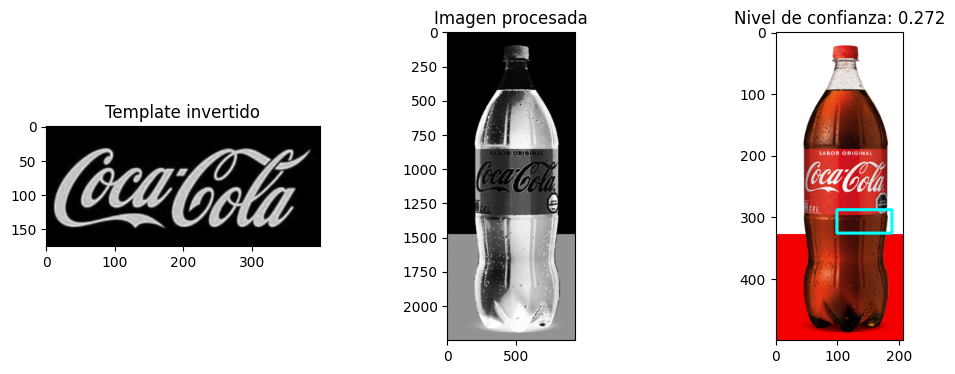


=== Procesando imagen: coca_logo_2.png ===
[Canny] Score: 0.136, Escala: 1.75
Imagen: coca_logo_2.png
Máximo: 0.136
Nivel de Confianza:  0.864
Escala: 1.75


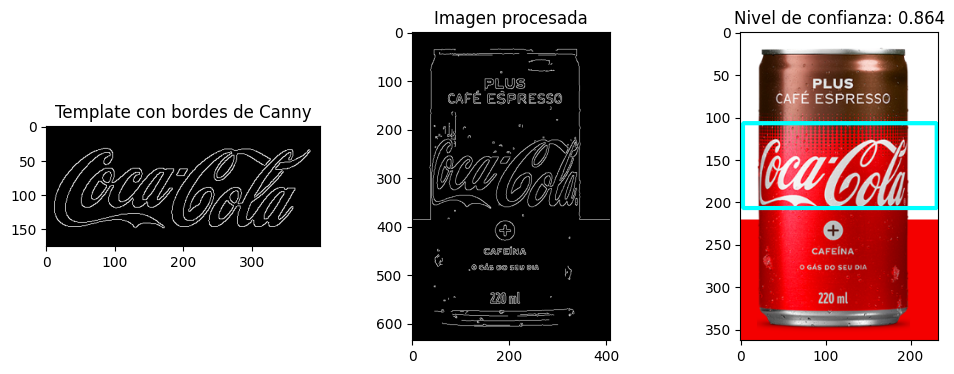

[Inversión] Score: 0.714, Escala: 4.5
Imagen: coca_logo_2.png
Máximo: 0.714
Nivel de Confianza:  0.286
Escala: 4.5


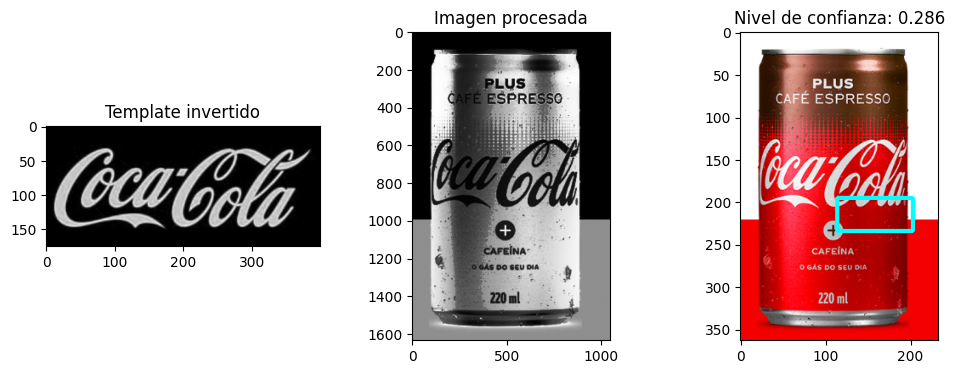


=== Procesando imagen: coca_multi.png ===
[Canny] Score: 0.181, Escala: 4
Imagen: coca_multi.png
Máximo: 0.181
Nivel de Confianza:  0.819
Escala: 4


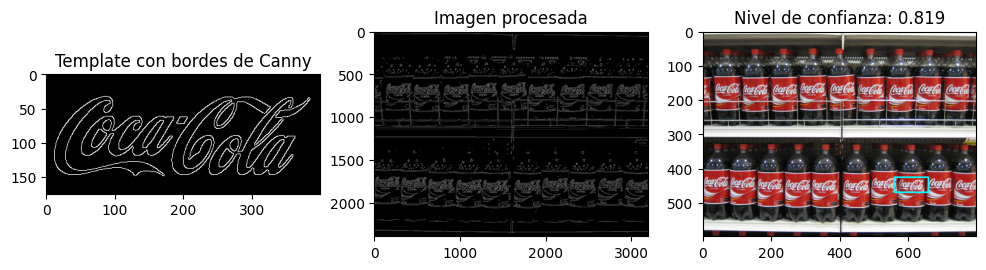

[Inversión] Score: 0.758, Escala: 2
Imagen: coca_multi.png
Máximo: 0.758
Nivel de Confianza:  0.242
Escala: 2


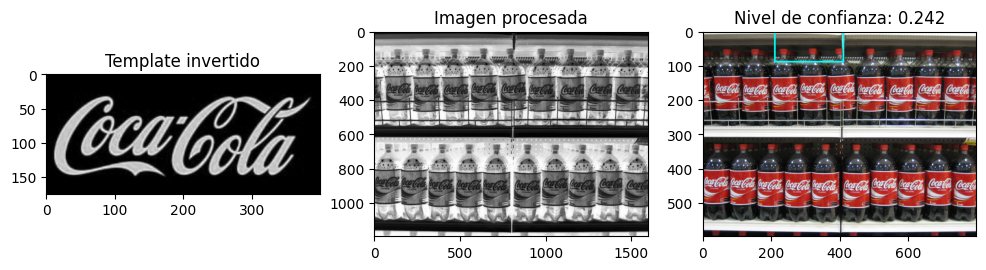


=== Procesando imagen: coca_retro_1.png ===
[Canny] Score: 0.181, Escala: 0.7500000000000002
Imagen: coca_retro_1.png
Máximo: 0.181
Nivel de Confianza:  0.819
Escala: 0.7500000000000002


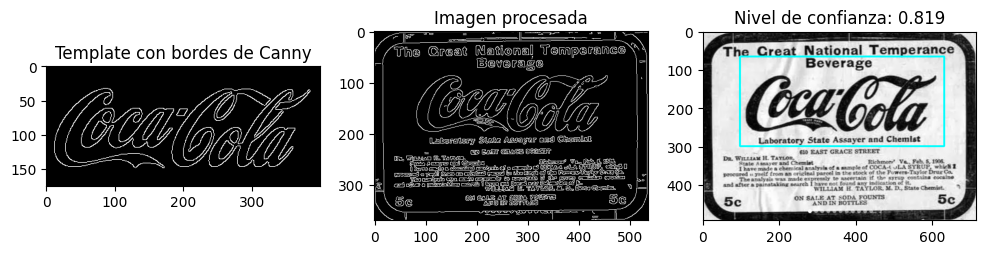

[Inversión] Score: 0.807, Escala: 0.7500000000000002
Imagen: coca_retro_1.png
Máximo: 0.807
Nivel de Confianza:  0.193
Escala: 0.7500000000000002


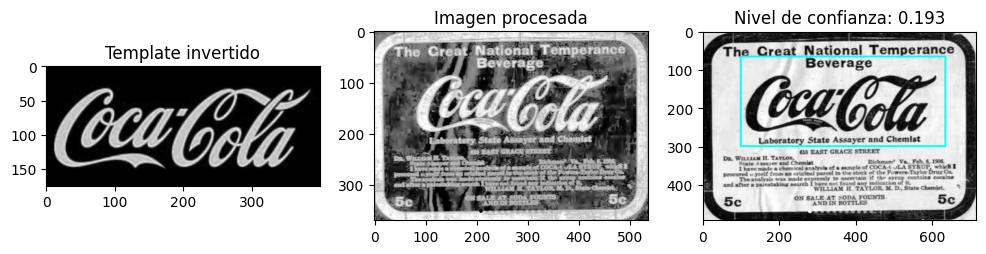


=== Procesando imagen: coca_retro_2.png ===
[Canny] Score: 0.224, Escala: 2.5
Imagen: coca_retro_2.png
Máximo: 0.224
Nivel de Confianza:  0.776
Escala: 2.5


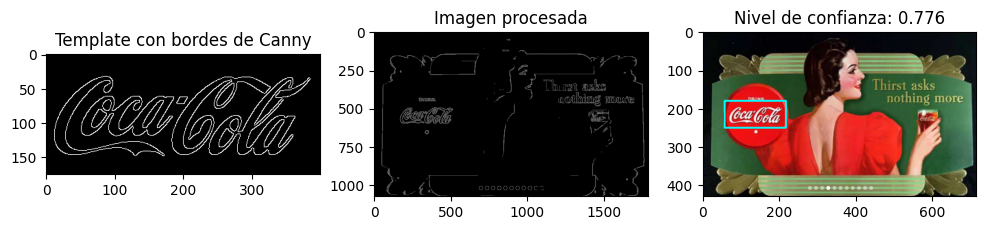

[Inversión] Score: 0.752, Escala: 4.5
Imagen: coca_retro_2.png
Máximo: 0.752
Nivel de Confianza:  0.248
Escala: 4.5


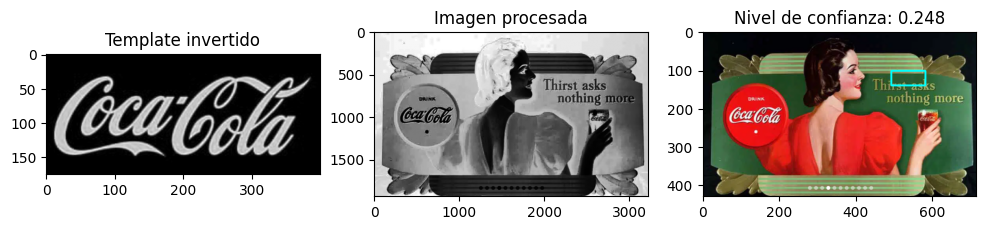


=== Procesando imagen: logo_1.png ===
[Canny] Score: 0.143, Escala: 1.5
Imagen: logo_1.png
Máximo: 0.143
Nivel de Confianza:  0.857
Escala: 1.5


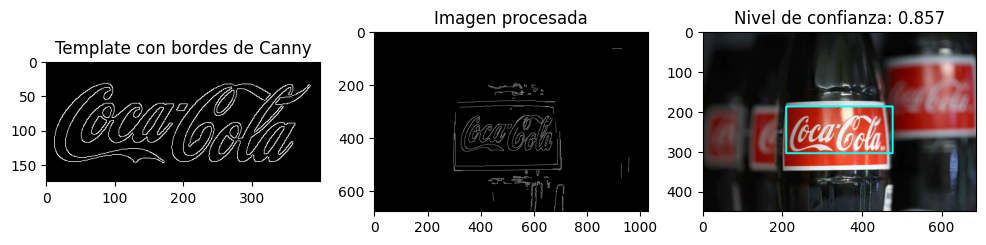

[Inversión] Score: 0.743, Escala: 4.5
Imagen: logo_1.png
Máximo: 0.743
Nivel de Confianza:  0.257
Escala: 4.5


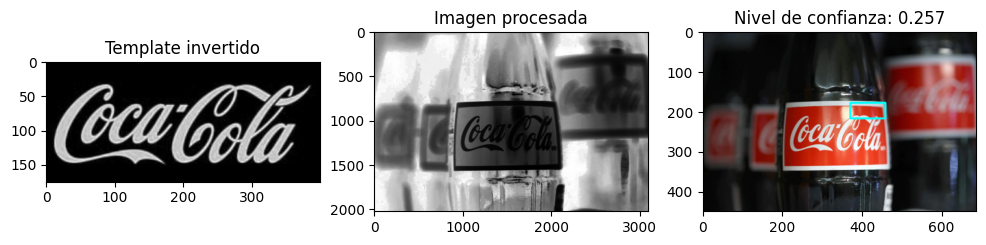

In [7]:
for image in images:
    print(f"\n=== Procesando imagen: {image.name} ===")

    # Método 1: Canny
    rect_canny, score_canny, scale_canny, canny_img = template_matcher.detect_single(image)
    print(f"[Canny] Score: {score_canny:.3f}, Escala: {scale_canny}")
    template_matcher.visualize_single(image, rect_canny, score_canny, scale_canny, canny_img)

    # Método 2: Inversión de colores
    rect_inv, score_inv, scale_inv, processed_img = template_matcher.detect_single_inverted(image)
    print(f"[Inversión] Score: {score_inv:.3f}, Escala: {scale_inv}")
    template_matcher.visualize_single(image, rect_inv, score_inv, scale_inv, processed_img, template_view='inverted')

#### Conclusiones

- El **método de inversión** resulta útil en imágenes donde el template original tiene **polaridad opuesta** respecto al objeto a detectar (por ejemplo, letras blancas sobre fondo oscuro en el template, pero letras oscuras sobre fondo claro en la imagen).
- El **método de Canny** logra detectar correctamente el logotipo en **todas las imágenes analizadas**, mostrando gran robustez frente a variaciones de color, fondo y textura. Esto se debe a que opera sobre bordes, eliminando dependencia directa del color o intensidad.
- Por el contrario, el **método de inversión de colores** solo logra una detección adecuada en **un caso particular**, en el cual la imagen tiene una **polaridad invertida** respecto al template original (letras oscuras sobre fondo claro, en lugar de claras sobre fondo oscuro).
- Este resultado evidencia que el método de inversión puede ser útil en **casos muy específicos** donde el contraste o la polaridad juegan un rol importante, pero no es confiable como estrategia general.
- En resumen, el enfoque basado en **Canny es claramente superior** para este conjunto de imágenes, aunque **considerar ambos métodos puede servir como estrategia complementaria** cuando se trabaje con bases de datos más variadas o difíciles.


### Ejercicio 2) Se emplea el método *detect_multiple* para encontar todas las coincidencias del template que superen el umbral definido en la variable *threshold* en la imagen coca_multi.png

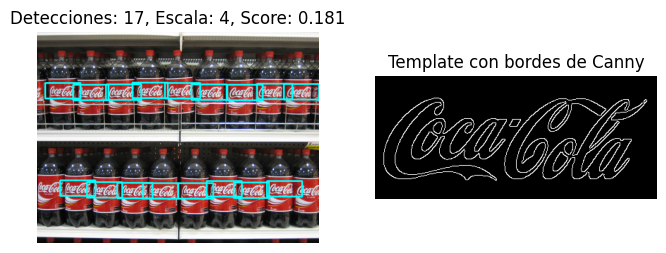

In [8]:
# Cargamos ./images/coca_multi.png para detección múltiple
image_coca_multiple = ImageData('./images/coca_multi.png')
# detectamos múltiples coincidencias:

rects, scores, best_score, best_scale = template_matcher.detect_multiple(image_coca_multiple, threshold=0.1355)
template_matcher.visualize_multiple(image_coca_multiple, rects, best_score, best_scale)

Luego de ejecutar el método de detección múltiple, se observa una correcta identificación de todos los logos visibles menos dos en las esquinas de la fila inferior. Al reducir el valor del threshold el algoritmo ya introduce una cantidad significativa de falso positivos.
Se debió utilizar la supresión de no máximos mediante la librería *non_max_suppression* debido a la multiplicidad de recuadros dibujados en la imagen final.


#### Comparación entre detección con Canny e Inversión de Colores (Múltiples detecciones)

**Introducción**

En esta sección se comparan dos enfoques de template matching aplicados a una imagen con múltiples instancias del logo de Coca-Cola:

- **Método 1 - Canny**: Se aplica detección de bordes al template y a la imagen, buscando coincidencias a partir de contornos.
- **Método 2 - Inversión + Ecualización**: Se invierte el color del template y la imagen para mejorar el contraste, aplicando posteriormente ecualización de histograma.

Ambos métodos se evalúan usando `cv.matchTemplate` y se visualizan los resultados con los rectángulos que indican las detecciones más relevantes.

[Canny] Detecciones: 17 | Mejor Score: 0.181 | Escala: 4


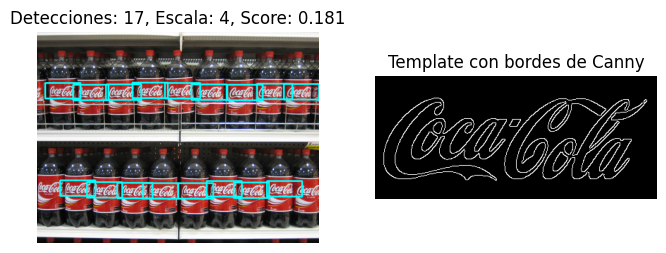

[Inversión] Detecciones: 29 | Mejor Score: 0.598 | Escala: 1.75


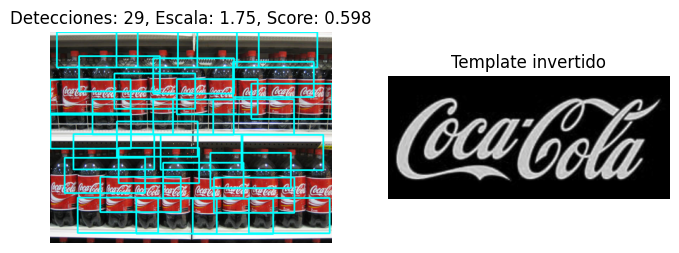

In [9]:
# --- Método 1: Canny ---
threshold_canny = 0.1355
rects_canny, scores_canny, best_score_canny, best_scale_canny = template_matcher.detect_multiple(
    image_coca_multiple,
    threshold=threshold_canny
)
print(f"[Canny] Detecciones: {len(rects_canny)} | Mejor Score: {best_score_canny:.3f} | Escala: {best_scale_canny}")
template_matcher.visualize_multiple(image_coca_multiple, rects_canny, best_score_canny, best_scale_canny)

# --- Método 2: Inversión + ecualización ---
threshold_inversion = 0.08
rects_inv, scores_inv, best_score_inv, best_scale_inv = template_matcher.detect_multiple_inverted(
    image_coca_multiple,
    threshold=threshold_inversion
)
print(f"[Inversión] Detecciones: {len(rects_inv)} | Mejor Score: {best_score_inv:.3f} | Escala: {best_scale_inv}")
template_matcher.visualize_multiple(image_coca_multiple, rects_inv, best_score_inv, best_scale_inv, template_view='inverted')

#### Conclusión

El método **Canny** demuestra ser más robusto para detectar múltiples instancias del logo de Coca-Cola. Logra identificar correctamente casi todos los casos presentes en la imagen, incluso cuando hay variaciones en escala, iluminación o fondo. Esto se debe a que los bordes del logo se mantienen consistentes visualmente, lo que permite una coincidencia efectiva basada en contornos.

En cambio, el método de **inversión de colores** con ecualización obtiene en algunos casos un score más alto, pero **genera numerosas detecciones incorrectas**. Esto se debe a que la polaridad (distribución de claros y oscuros) del template invertido no coincide con la de la mayoría de los logos en la imagen. Por lo tanto, este enfoque **solo resulta útil cuando el logo en la imagen tiene una polaridad invertida respecto del template original**.

En resumen, **Canny ofrece un rendimiento más confiable y generalizable**, mientras que **la inversión puede ser efectiva solo en contextos específicos** donde la polaridad visual coincide con la del template invertido.

### Ejercicio 3) Se emplea el método *detect_multiple* para encontar todas las coincidencias del template que superen el umbral definido en la variable *threshold* en todas las imágenes del dataset.

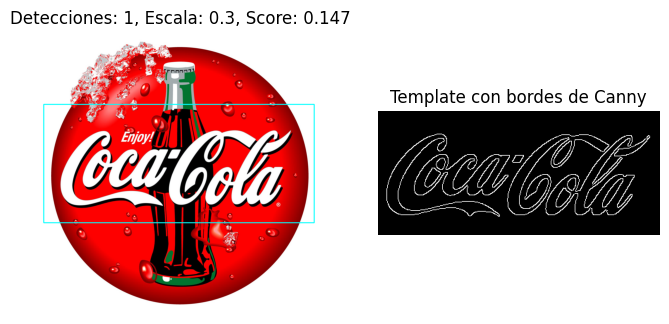

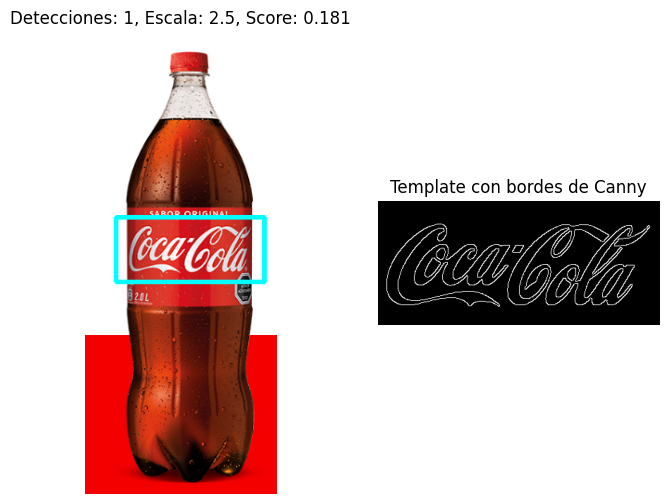

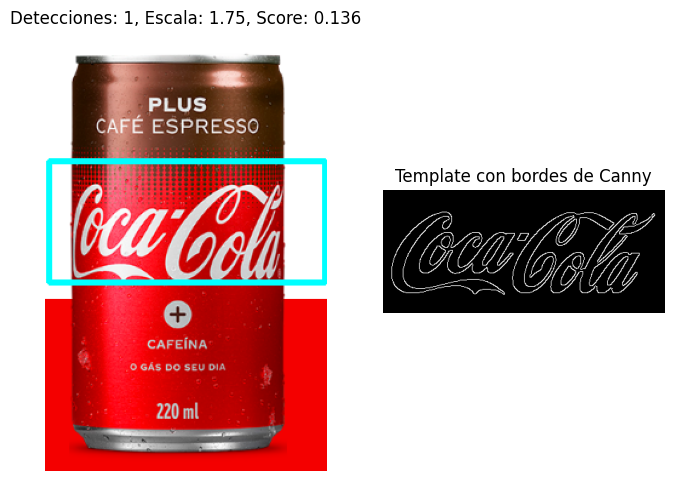

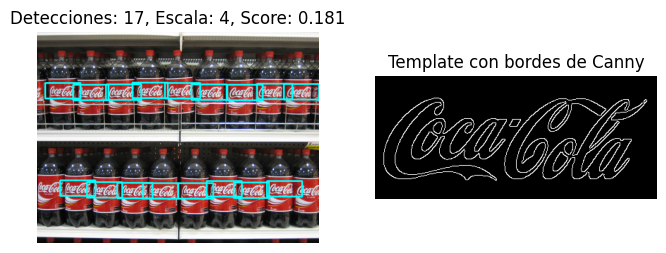

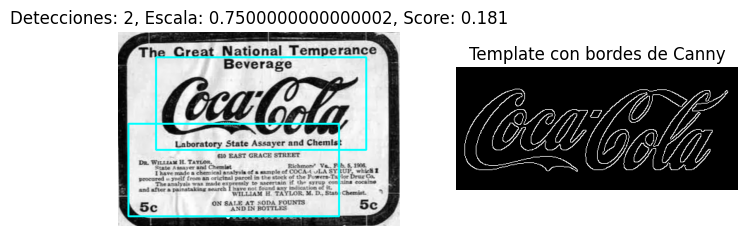

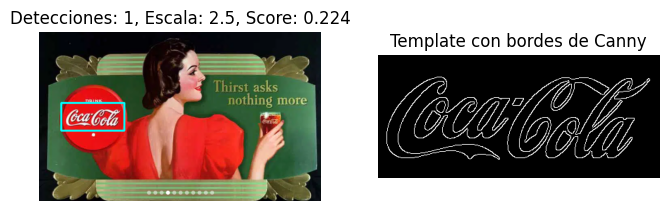

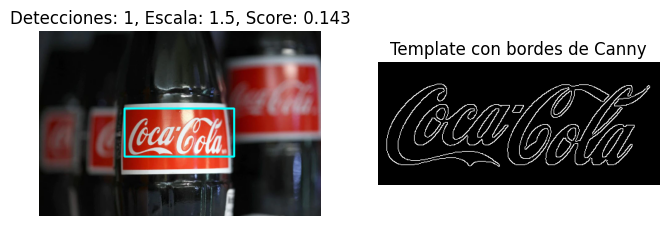

In [10]:
# Bucle para procesar cada imagen detectando el template
for image in images:
    rects, scores, best_score, best_scale = template_matcher.detect_multiple(image, threshold=0.1355)
    template_matcher.visualize_multiple(image, rects, best_score, best_scale)

Se observa un comportamiento estable del método con buen reconocimiento del template en todas las imágenes y a excepción de la imagen "coca_retro_1.png" no se producen falsos positivos. El inconveniente que introdujo el usar un rango tan variado de imágenes resulta en no poder tener un valor de threshold común que no resulte en errores de detección. Cambiando los parámetros del template que solucionen a esta imagen introducen falsos en otras, por lo que optó por culminar el trabajo indicando ese error.

### Detección múltiple usando método de coeficientes normalizados
En los puntos anteriores se usó el método cv.TM_CCORR_NORMED para el template matching. Ahora comparamos con el método cv.TM_CCOEFF_NORMED, ajustando el umbral de detección:


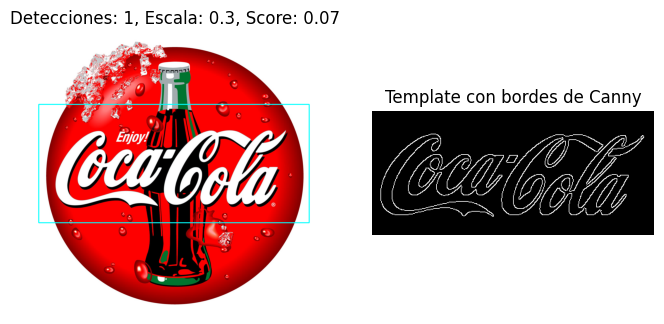

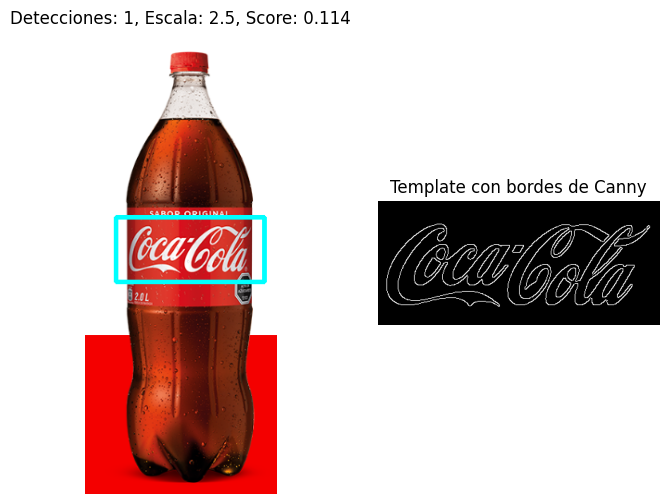

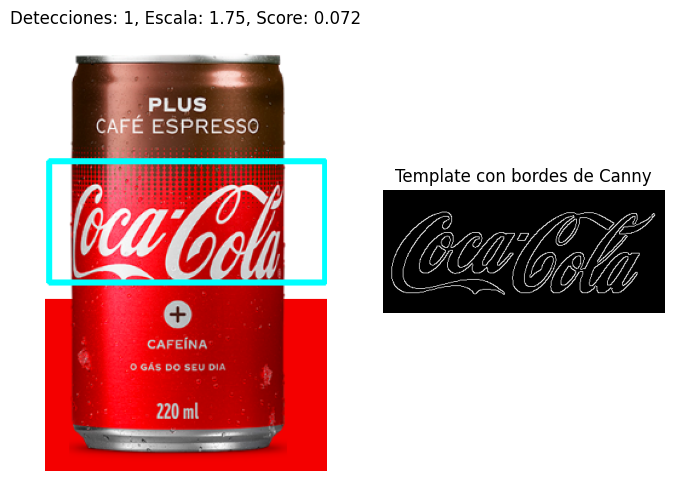

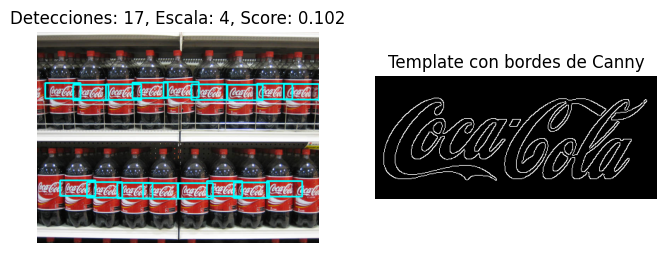

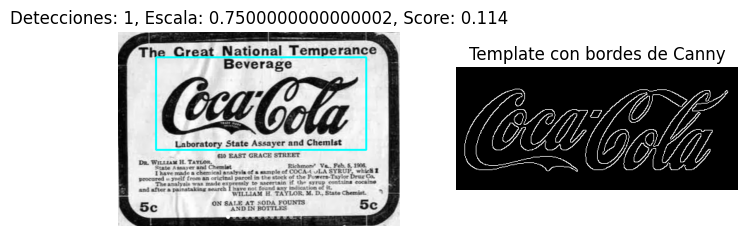

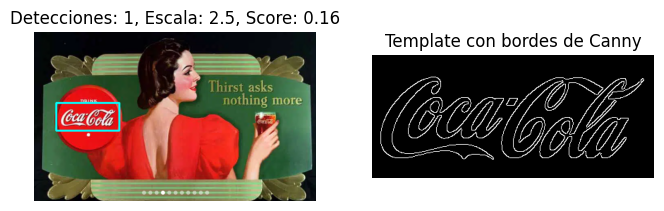

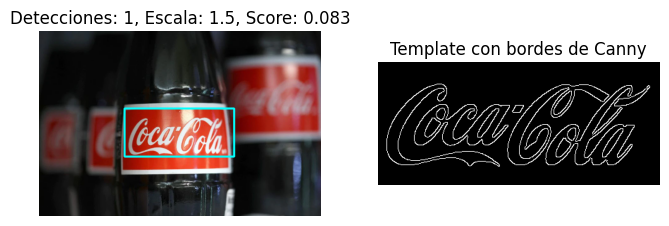

In [11]:
template_matcher_coef = TemplateMatcher('./template/pattern.png', method=cv.TM_CCOEFF_NORMED)


# Bucle para procesar cada imagen detectando el template
for image in images:
    rects, scores, best_score, best_scale = template_matcher_coef.detect_multiple(image, threshold=0.06)
    template_matcher_coef.visualize_multiple(image, rects, best_score, best_scale)

Con este método se observa una mejor separación entre positivo y negativo, ya que fue posible eliminar el falso positivo en la imágen "coca_retro_1.png" ajustando el umbral, aunque sí se mantienen los dos falsos negativos de la imagen "coca_multi.png" presentes con el método anterior. Éstos últimos podría deberse a que se encuentran en los bordes de la imagen con la etiqueta recortada, por lo que no logra detectarlos con el umbral fijado.